In [8]:
%matplotlib widget
import numpy
import pyresample
import cartopy
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
import glob

# Read VNP02/03

In [9]:
vnp03 = netCDF4.Dataset('viirs/VNP03IMG.A2021199.2100.001.2021200024057.nc')
lats = vnp03['geolocation_data']['latitude'][:]
lons = vnp03['geolocation_data']['longitude'][:]

In [10]:
vnp02 = netCDF4.Dataset('viirs/VNP02IMG.A2021199.2100.001.2021200025428.nc')
i1 = vnp02['observation_data']['I01'][:]
i2 = vnp02['observation_data']['I02'][:]
i3 = vnp02['observation_data']['I03'][:]
i4 = vnp02['observation_data']['I04'][:]
i5 = vnp02['observation_data']['I05'][:]
data = numpy.ma.stack([i1, i2, i3, i4, i5], axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


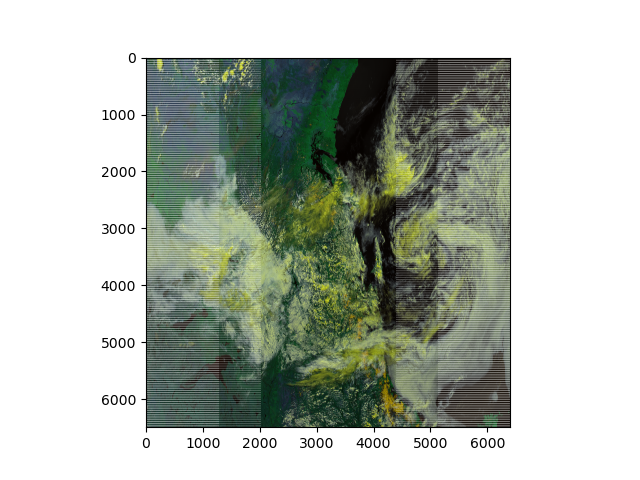

In [11]:
fig, ax = matplotlib.pyplot.subplots()
matplotlib.pyplot.imshow(data[:, :, 0:3])

# Read GOES 
We read a GOES image to pull out the grid parameters. 

We also can read the radiances 

In [12]:
goes_file = 'goes/OR_ABI-L1b-RadC-M6C07_G17_s20211992101177_e20211992103561_c20211992103589.nc'
goes = netCDF4.Dataset(goes_file)
goes_c7 = goes['Rad'][:]

area_def, cf_info = pyresample.utils.load_cf_area(goes_file, variable='goes_imager_projection', x='x', y='y')
area_def

/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Area ID: goes_imager_projection
Description: goes_imager_projection
Projection: {'ellps': 'GRS80', 'h': '35786023', 'lon_0': '-137', 'no_defs': 'None', 'proj': 'geos', 'sweep': 'x', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2500
Number of rows: 1500
Area extent: (-2505021.6464, 1583173.822, 2505021.6464, 4589199.7649)

In [13]:
lons_goes, lats_goes = area_def.get_lonlats()

# Do the resampling

In [15]:
swath_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)

## Nearest Neighborhood
https://pyresample.readthedocs.io/en/latest/swath.html#resample-nearest

In [16]:
result = pyresample.kd_tree.resample_nearest(swath_def, data, area_def, radius_of_influence=1000, epsilon=0.5, fill_value=None)

## Gaus
https://pyresample.readthedocs.io/en/latest/swath.html#resample-gauss

In [17]:
sigmas = [500, 500, 500, 500, 500]
result = pyresample.kd_tree.resample_gauss(swath_def, data, area_def, radius_of_influence=1000, sigmas=sigmas, fill_value=None)

/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 8 neighbours within 1000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


## Bilinear
https://pyresample.readthedocs.io/en/latest/swath.html#resample-bilinear

In [18]:
import pyresample.bilinear

/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray, dask, and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray, dask, and/or zarr not found, XArrayBilinearResampler won't be available.")


In [20]:
source_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)
result = pyresample.bilinear.resample_bilinear(data, swath_def, area_def, radius=50e3, neighbours=32, 
                                               nprocs=1, fill_value=None, reduce_data=True, segments=None, epsilon=0)

/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pyresample/bilinear/_numpy_resampler.py:86: FutureWarning: Usage of resample_bilinear() is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


# Plot

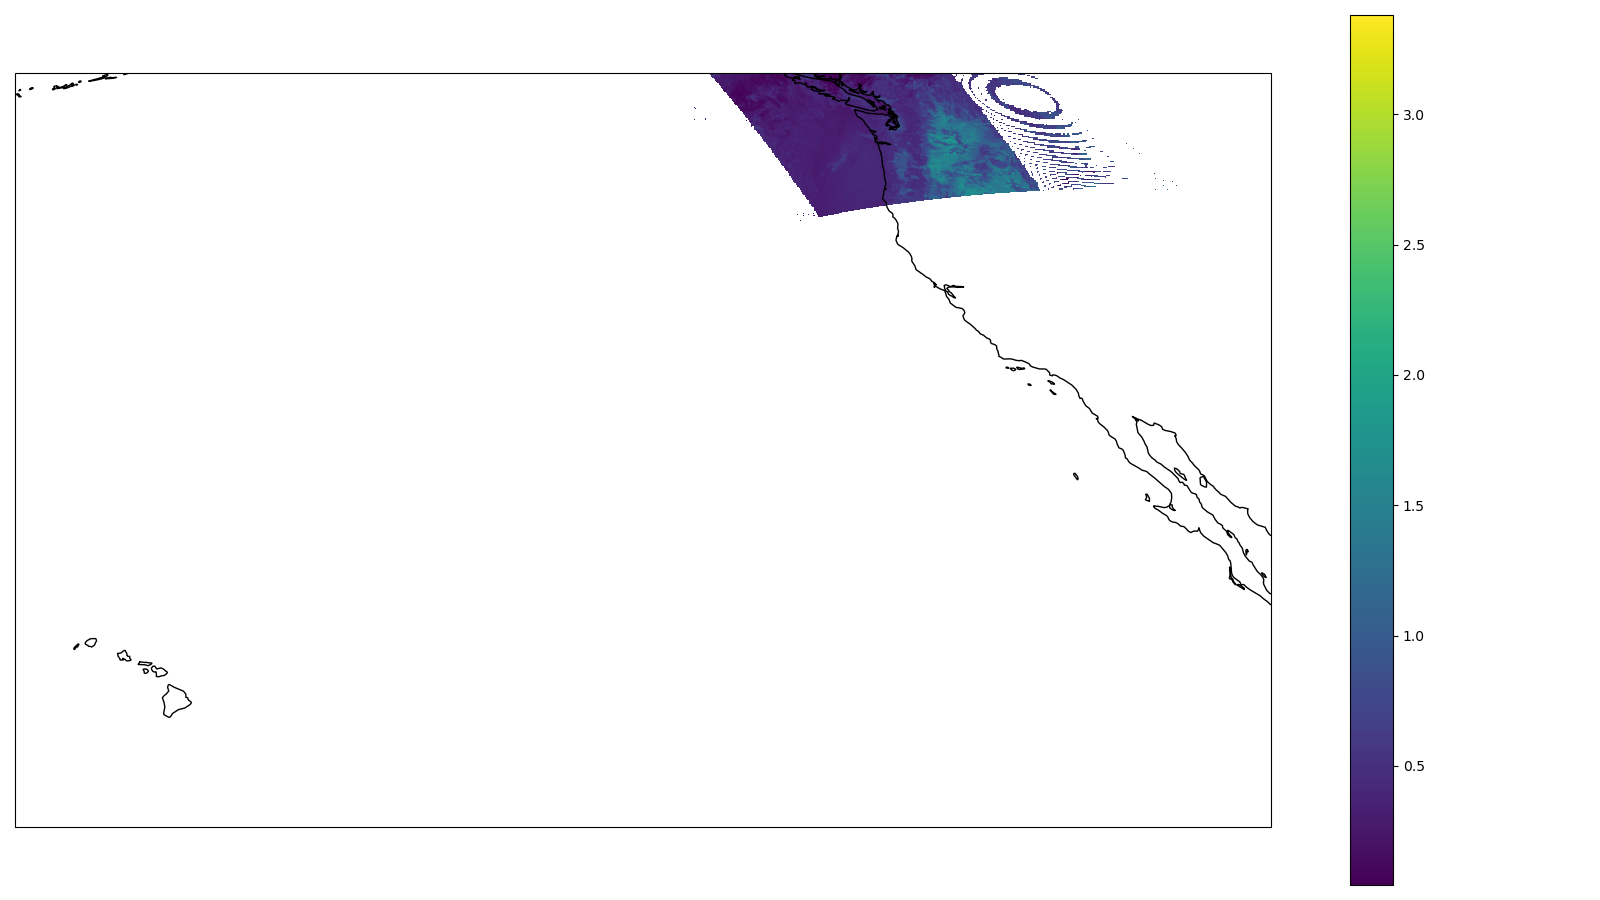

In [21]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(figsize=(16,9),subplot_kw=dict(projection=crs))
coastlines = ax.coastlines()  
ax.set_global()

img = plt.imshow(result[:,:,3], transform=crs, extent=crs.bounds, origin='upper')
cbar = plt.colorbar()
fig.tight_layout()

# Saving results

In [22]:
import pickle

In [23]:
with open('pickles/viirs_original.pickle', 'wb') as f:
    pickle.dump(data, f)

In [24]:
with open('pickles/viirs_resampled.pickle', 'wb') as f:
    pickle.dump(result, f)

In [25]:
with open('pickles/goes_c7.pickle', 'wb') as f:
    pickle.dump(goes_c7, f)    

In [27]:
with open('pickles/goes_lat.pickle', 'wb') as f:
    pickle.dump(lats_goes, f)    

In [29]:
with open('pickles/goes_lon.pickle', 'wb') as f:
    pickle.dump(lons_goes, f)    

In [32]:
with open('pickles/viirs_lat.pickle', 'wb') as f:
    pickle.dump(lats, f)    

In [33]:
with open('pickles/viirs_lon.pickle', 'wb') as f:
    pickle.dump(lons, f)    

# Alternatively, we define the crs with cartopy

In [ ]:
transform_17 = cartopy.crs.Geostationary(central_longitude=-137.0, 
                                         satellite_height=35786023.0)

In [ ]:
area_def = geometry.AreaDefinition(area_id='conus', 
                                   proj_id='geostationary',
                                   description='GOES17 grid over conus',                                    
                                   projection=transform_17.proj4_params,
                                   width=5000,
                                   height=3000,
                                   area_extent=(-2505021.6335, 1583173.5682, 2505021.6335, 4589199.4854))

swath_def = geometry.SwathDefinition(lons=lons, lats=lats)
swath_con = image.ImageContainerNearest(data, swath_def, radius_of_influence=0.1)
area_con = swath_con.resample(area_def)
result = area_con.image_data